# Performance

In [2]:
import sys
sys.path.insert(0, 'D:/work/Personal/ml_project_2_deep_hedging/src')
sys.path.insert(1, 'D:/work/Personal/ml_project_2_deep_hedging/data')

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm
from simulation import *
from env import StockTradingEnv
from agent import DDPG_Hedger
from network import MLP

d:\work\Personal\ml_project_2_deep_hedging\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generate data and appply classical hedging

In [4]:
T = 20 # length of simulation 20=1 month, 60 = three months
S0 = 100 # starting price
K = 100 # strike price
sigma = 0.2 # volatility
r = 0 # risk-free rate
q = 0 # dividend yield
mu = 0.05 # expected return on stock
kappa = 0.01 # trading cost per unit traded
dt = 1 # hedging time step
notional = 100 # how many stocks the option is on
rho = -0.4 # correlation of stochastic volatility process
v = 0.6
sigma0 = 0.2 # starting volatility
c = 1.5 #standard deviation coefficient
ds = 0.01

n = 3000 # number of simulatied paths
days = 250 # number of days in a year
freq = 1 # trading frequency
np.random.seed(94673)

- 1st run: save train data
- 2nd run or more: ignore this process and import data and run afterwards.

In [5]:
S_gbm, p_gbm, d_gbm = simulateGBM(n, T, dt, S0, mu, r, q, sigma, days, freq, K)

S_sabr, s_sabr, iv_sabr, p_sabr, delta_sabr, delta_sabr_bl = simulateSABR(
    n, T, dt, S0, mu, r, q, sigma, days, freq, rho, ds, v, K)

100%|██████████| 19/19 [00:00<00:00, 4765.68it/s]
D:\work/Personal/ml_project_2_deep_hedging/src\simulation.py:124: RuntimeWarning: invalid value encountered in divide
  imp_vol = np.where(f == K, atm, atm * xi / xi_func)


In [6]:
# classical hedging implementations (trading strategies)
trading_gbm, holding_gbm = hedgingStrategy("GBM",notional, d_gbm, 0)
trading_sabr, holding_sabr, trading_sabr_bl, holding_sabr_bl = hedgingStrategy("SABR",notional, delta_sabr, delta_sabr_bl)

In [7]:
# Accounting PnL
APL_gbm, holding_lagged_gbm = APL_process(S_gbm, p_gbm*notional, holding_gbm, K, notional, kappa)
APL_sabr, holding_lagged_sabr = APL_process(S_sabr, p_sabr*notional, holding_sabr, K, notional, kappa)
APL_sabr_bl, holding_lagged_sabr_bl = APL_process(S_sabr, p_sabr*notional, holding_sabr_bl, K, notional, kappa)

In [8]:
# Evaluation:
# Y(0) (take mean), 
# mean of  cost as percentage of option price,
# std of  cost as percentage of option price.

Y_gbm, mPerc_gbm, stdPerc_gbm = evaluate(APL_gbm, p_gbm, c, notional) 
Y_sabr, mPerc_sabr, stdPerc_sabr = evaluate(APL_sabr, p_sabr, c, notional)
Y_sabr_bl, mPerc_sabr_bl, stdPerc_sabr_bl = evaluate(APL_sabr_bl, p_sabr, c, notional)

In [9]:
print("GBM")
print("Y0: ", np.mean(Y_gbm))
print("mean cost (%): ", mPerc_gbm)
print("std cost (%): ", stdPerc_gbm)
print("\n")
print("SABR delta")
print("Y0: ", np.mean(Y_sabr))
print("mean cost (%): ", mPerc_sabr)
print("std cost (%): ", stdPerc_sabr)
print("\n")
print("SABR Bartlett")
print("Y0: ", np.mean(Y_sabr_bl))
print("mean cost (%): ", mPerc_sabr_bl)
print("std cost (%): ", stdPerc_sabr_bl)

GBM
Y0:  135.3827886076877
mean cost (%):  0.3017732559712498
std cost (%):  0.19880406280782928


SABR delta
Y0:  136.3208466308123
mean cost (%):  0.302091636099821
std cost (%):  0.20136328646715285


SABR Bartlett
Y0:  136.38926780116168
mean cost (%):  0.3026634253760105
std cost (%):  0.2011842428444716


## data saving

In [10]:
result_folder_path = f"data/{T//20}month/{freq}d"
os.makedirs(result_folder_path, exist_ok=True)

# define data
# save to csv file
np.savetxt(f'data/{T//20}month/{freq}d/asset_price_GBM_sim.csv', S_gbm, delimiter=',')
np.savetxt(f'data/{T//20}month/{freq}d/option_price_GBM_sim.csv', p_gbm*notional, delimiter=',')
np.savetxt(f'data/{T//20}month/{freq}d/asset_price_SABR_sim.csv', S_sabr, delimiter=',')
np.savetxt(f'data/{T//20}month/{freq}d/option_price_SABR_sim.csv', p_sabr*notional, delimiter=',')


S_mixed = np.vstack((S_gbm, S_sabr))
p_mixed = np.vstack((p_gbm*notional, p_sabr*notional))
print(S_mixed.shape)
print(p_mixed.shape)
np.savetxt(f"data/{T//20}month/{freq}d/asset_price_mixed_sim.csv", S_mixed, delimiter=",")
np.savetxt(f"data/{T//20}month/{freq}d/option_price_mixed_sim.csv", p_mixed, delimiter=",")


(6000, 20)
(6000, 20)


# Deep RL Method 

In [13]:

env = StockTradingEnv(maturity=1, frequency=1, data_type="GBM", test_env=True)

# set same dataset as delta hedging
env.asset_price = S_gbm
env.option_price = p_gbm

nState, nAction = env.observation_space.shape[0], \
                    env.action_space.shape[0]  # 3, 1

# we use hidden layer size of 32, 64 as the author used.
actor = MLP(nState, 16, nAction, "Sigmoid")
qnet_1 = MLP(nState + nAction, 16, nAction, "")
qnet_2 = MLP(nState + nAction, 16, nAction, "")
agent = DDPG_Hedger(actor, qnet_1, qnet_2, 0, 0, 1, 32)
agent.load('v8_new')

In [14]:
path_indice, rewards_path, action_path = [], [], []
for i in range(n):
    state = env.reset()
    env.path_idx = i
    
    path_indice.append(env.path_idx)
    rewards, actions = [], [0]
    done = False
    
    if i%1000 == 0:
        print(f'Episode {i}')
    while not done:
        normalized_state = env.normalize(state)
        
        # action without exploration
        action = agent.act(normalized_state, 0)
        
        next_state, reward, done = env.step(action)

        state = next_state
        rewards.append(np.round(reward, 2))
        actions.append(np.round(action, 2)) # each episode [0.99, 13.20 ... 100 ] shape (1,60) 
        
        if done:
            break

    rewards_path.append(rewards) # <- (numEpisode=25000, 60)
    action_path.append(actions) # (numEpisode=25000, 60) = holding_gbm

Episode 0
Episode 1000
Episode 2000


In [49]:
# get action array as holding gbm
apl_gbm_rl, holding_lagged_rl = APL_process(S_gbm, p_gbm*notional, np.array(action_path), K, notional, kappa)

In [50]:
Y_gbm_rl, mPerc_gbm_rl, stdPerc_gbm_rl = evaluate(apl_gbm_rl, p_gbm, c, notional) 

In [51]:
print("GBM")
print("Y0: ", np.mean(Y_gbm))
print("mean cost (%): ", mPerc_gbm)
print("std cost (%): ", stdPerc_gbm)

print("GBM RL")
print("Y0: ", np.mean(Y_gbm_rl))
print("mean cost (%): ", mPerc_gbm_rl)
print("std cost (%): ", stdPerc_gbm_rl)

GBM
Y0:  232.5832075191567
mean cost (%):  0.3103369148956763
std cost (%):  0.18994841560819478
GBM RL
Y0:  1138.6801914838259
mean cost (%):  1.551102008324295
std cost (%):  0.9087786063302595


# Results

- add reward plots 
- episode total reward histograms (classic delta, RL agent)

In [52]:

#bins = numpy.linspace(-10, 10, 100)


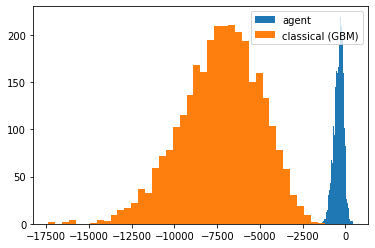

In [26]:
# ep 1 = 800, ep 2 = 67, ep 3 = -123 cumulative (up to 25000 episodes) 

# (25000, 2): 2 means classical delta and RL agent hedging.

total_episode_rewards_gbm = np.sum(np.asarray(APL_gbm), axis=1)
total_episode_rewards_agent = np.sum(np.asarray(rewards_path), axis=1)
plt.hist(total_episode_rewards_agent,bins=40,label='agent')
plt.hist(total_episode_rewards_gbm,bins=40,label='classical (GBM)')
plt.legend(loc='upper right')
plt.show()



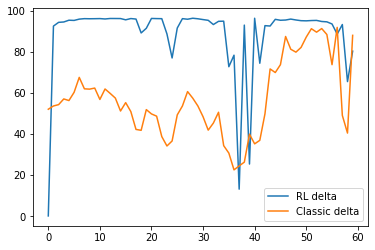

In [31]:
plt.plot(np.array(action_path)[50], label='RL delta')
plt.plot(holding_gbm[50], label='Classic delta')
plt.xlabel('')
plt.legend()
plt.show()

### SEED 7777

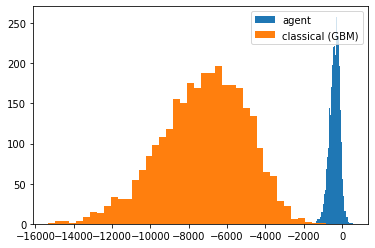

In [16]:
total_episode_rewards_gbm = np.sum(np.asarray(APL_gbm), axis=1)
total_episode_rewards_agent = np.sum(np.asarray(rewards_path), axis=1)
plt.hist(total_episode_rewards_agent,bins=40,label='agent')
plt.hist(total_episode_rewards_gbm,bins=40,label='classical (GBM)')
plt.legend(loc='upper right')
plt.show()

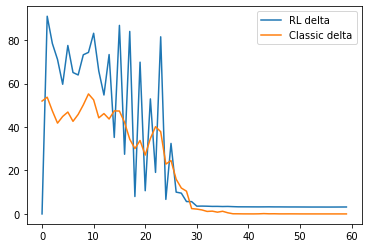

In [18]:
plt.plot(np.array(action_path)[50], label='RL delta')
plt.plot(holding_gbm[50], label='Classic delta')
plt.xlabel('')
plt.legend()
plt.show()

### SEED 8

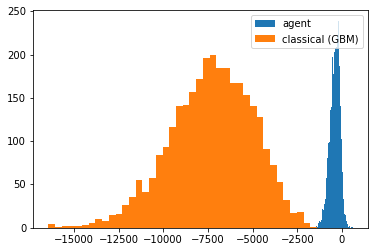

In [36]:
total_episode_rewards_gbm = np.sum(np.asarray(APL_gbm), axis=1)
total_episode_rewards_agent = np.sum(np.asarray(rewards_path), axis=1)
plt.hist(total_episode_rewards_agent,bins=40,label='agent')
plt.hist(total_episode_rewards_gbm,bins=40,label='classical (GBM)')
plt.legend(loc='upper right')
plt.show()

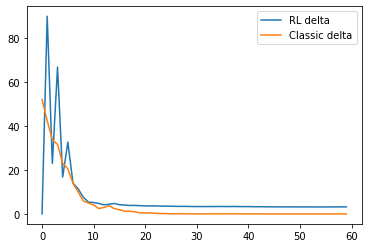

In [37]:

plt.plot(np.array(action_path)[50], label='RL delta')
plt.plot(holding_gbm[50], label='Classic delta')
plt.xlabel('')
plt.legend()
plt.show()

### SEED 94673

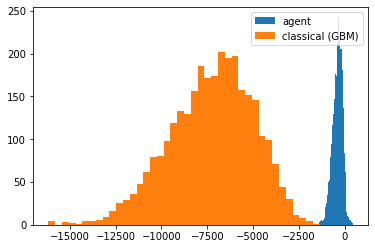

In [53]:
total_episode_rewards_gbm = np.sum(np.asarray(APL_gbm), axis=1)
total_episode_rewards_agent = np.sum(np.asarray(rewards_path), axis=1)
plt.hist(total_episode_rewards_agent,bins=40,label='agent')
plt.hist(total_episode_rewards_gbm,bins=40,label='classical (GBM)')
plt.legend(loc='upper right')
plt.show()

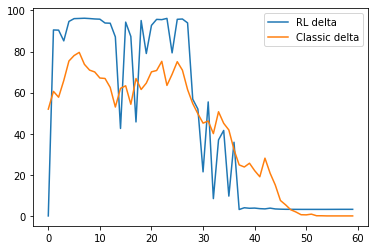

In [54]:

plt.plot(np.array(action_path)[50], label='RL delta')
plt.plot(holding_gbm[50], label='Classic delta')
plt.xlabel('')
plt.legend()
plt.show()